# Семинар 2: Введение в tensorflow

На этом семинаре мы познакомимся с классическим фреймворком `tensorflow`, разберёмся с автоматическим дифференцированием, а также обучим нашу первую нейросеть.

In [1]:
import tensorflow as tf

# Как устроен tf изнутри?

Идея tensorflow заключается в построении так называемых **графов вычислений**, где вершины представляют из себя **тензоры** (многомерные массивы, в точности как `np.array` в знакомом вам `numpy`)вместе с **операции** над этими тензорами, а рёбра -- **передачу данных из одной операции в другую**.

**ВНИМАНИЕ!**

Вводя каким-нибудь образом тензоры и проводя над ними операции в питоновском коде Вы эти операции **не запускаете**, а лишь **определяете их заранее**, конструируя при этом граф вычислений в памяти. Как запускать эти определённые только что операции для получения результата мы узнаем немного позже.

Два основных вида тензоров:

1. `tf.placeholder` -- это тензор, который необходимо инициализировать руками **на этапе запуска операции**. Удобно использовать его как мнимый вход нейронной сети, которому мы впоследствии присвоим данные для обучения и тестирования.
2. `tf.Variable` -- это тензор-переменная, который имеет некоторую **инициализацию по умолчанию**. Удобно под ним понимать обучаемые параметры нейронных сетей, линейных моделей и т.п.


In [2]:
# Когда Вы создаёте плейсхолдер, обязательно необходимо указывать его тип, в данном случае это float32.
input_vector = tf.placeholder("float32",)

# Опционально Вы можете указать ещё и размерность тензора. 
# При запуске операций его размерность станет известна, лучше указывать это заранее, это очень полезно для дебага
input_vector_with_shape = tf.placeholder("float32", shape=(12,))

# Вы также можете указать размерности, которые заранее неизвестны (например, размер батча)
# при помощи ключевого слова None
input_vector_with_unknown_dim = tf.placeholder("float32", shape=(None, None, 12))

In [3]:
# Для переменных необходимо подать значение по умолчанию
# Тип переменной может быть определён по значению по умолчанию
variable_vector = tf.Variable(0.)

Ниже мы попробуем поделать какие-нибудь операции над тензорами. Они фактически точно такие же, как в `numpy`

In [5]:
tf.reset_default_graph()
x = tf.placeholder("float32", shape=(12,))
y = tf.placeholder("float32", shape=(12,))

# Поэлементное сложение, умножение, деление, whatever векторов
z = x + y
z = x - y
z = x * y

# Нахождеие среднего и среднего по всем элементам
# np.sum -> tf.reduce_sum
# np.mean -> tf.reduce_mean
s = tf.reduce_sum(x)
m = tf.reduce_mean(x)

# Математические операции
sin_x = tf.sin(x)
exp_x = tf.exp(x)

# Скалярное произведение
z = tf.tensordot(x, y, 1)

Список всевозможных трансформаций тензоров мы советуем искать в официальной документации к tensorflow, она очень качественно и подробно описана. В упражнениях мы попробуем давать хинты к операциям, которые необходимо использовать.

Tensorflow также предоставляет возможность использования уже инициализированных тензоров, в точности как в numpy.

In [6]:
# np.arange -> tf.range
range_12 = tf.range(12)

# np.zeros, np.ones -> tf.zeros, tf.ones
zeros_12 = tf.zeros(12)

**Упражнение** Попробуйте сами поиграть с тензорами и вычислить значение выражения

$$
    z = \cos \langle \cfrac{x}{x + y}, \cfrac{y}{x + y}\rangle
$$

Где $\langle \cdot, \cdot \rangle$ обозначает скалярное произведение векторов.

In [7]:
x = tf.placeholder("float32", shape=(12,))
y = tf.placeholder("float32", shape=(12,))

z = tf.cos(tf.tensordot(x / (x + y), y / (x + y), 1))

Можете не вникать в происходящее, просто запустите ячейку ниже для самопроверки. Должно вывести нечто близкое к -0.8893267.

In [8]:
import numpy as np
with tf.Session() as sess:
    print(sess.run(z, {x: np.ones(12), y: 2*np.ones(12)}))

-0.8893267


**Упражнение посложнее**. Попробуйте имплементировать квадратичную функцию потерь между двумя векторами:

$$
    MSE(x, y) = \sum_{i=1}^{n} (x_i - y_i)^2
$$

In [9]:
x = tf.placeholder("float32")
y = tf.placeholder("float32")

mse = tf.reduce_mean(tf.square(x - y))

Тесты для проверки.

In [10]:
# Tests
from sklearn.metrics import mean_squared_error

sess = tf.Session()

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = sess.run(mse, {x:el, y:el_2})
            if not np.allclose(true_mse,my_mse):
                print('Wrong result:')
                print('mse(%s,%s)' % (el,el_2))
                print("should be: %f, but your function returned %f" % (true_mse,my_mse))
                sess.close()
                raise ValueError("Что-то не так")
sess.close()
print("All tests passed")

All tests passed


## А как запускать операции?

Для того, чтобы граф вычислений запустился, необходимо населить все тензоры значениями, то есть положить их в оперативную память (или в память на Вашей видеокарте, если у вас таковая есть =)). Всё общение тензорфлоу с аппаратным памятью происходит через **сессии**.

Создавая сессию, Вы резервируете место в памяти под тензоры. Через сессию Вы также можете запускать операции.

**Замечание** 
Ваша запускаемая операция может зависеть от других операций, которые в свою очередь зависят от ещё каких-нибудь, и так далее. Тензорфлоу способен сам выявить какие операции от каких зависят и последовательно их запустить.

In [17]:
# создаём какой-нибудь простой граф вычислений
x = tf.ones(12)
y = tf.ones(12)
z = tf.reduce_sum(x + y)

# создаём сессию
sess = tf.Session()

# Запускаем операцию
print(sess.run(z))
sess.close()

24.0


Если ваша операция как-то зависит от placeholder'ов, то их необходимо явным образом инициализировать через так называемый **feed dict** -- это словарь, где ключом является ваш плейсхолдер, а значением -- numpy-массив с его значением. Этот словать нужно передать вторым аргументом в функции run.

In [18]:
# абсолютно тот же самый код, но уже с плейсхолдерами
x = tf.placeholder("float32", (12,))
y = tf.placeholder("float32", (12,))
z = tf.reduce_sum(x + y)

# создаём сессию
sess = tf.Session()

feed_dict = {x: np.ones(12), y: np.ones(12)}
# Запускаем операцию
print(sess.run(z, feed_dict=feed_dict))

sess.close()

24.0


**ВНИМАНИЕ** Обязательно закрывайте сессии при помощи `sess.close()`  или пользуйтесь конструкцией `with tf.Session() as sess:` после использования иначе Вы рискуете столкнуться с вопросом "А почему мой компьютер так медленно работает?"

## Подсчёт градиентов.

А теперь перейдём к самой главной функции тф'a, а именно к автоматическому подсчёту производных! Дело в том, что если Вы делаете какие-то поддерживаемые тф'ом операции над тензорами, тф умеет по этим операциям считать производные как производные функций многих переменных.

Для подсчёта градиента  $\cfrac{\partial y}{\partial x}$ Вы просто вызываете функцию `tf.gradients(y, x)`. 

Чтобы убедиться, что эта функция действительно считает градиенты, попробуем построить график произвольной гладкой функции и касательной к ней.

Напомним, что уравнение касательной к функции f(x) в точке ($x_0, y_0$) выглядит как 
$$
    y(x) = y'(x_0) \cdot (x - x_0) + y_0
$$

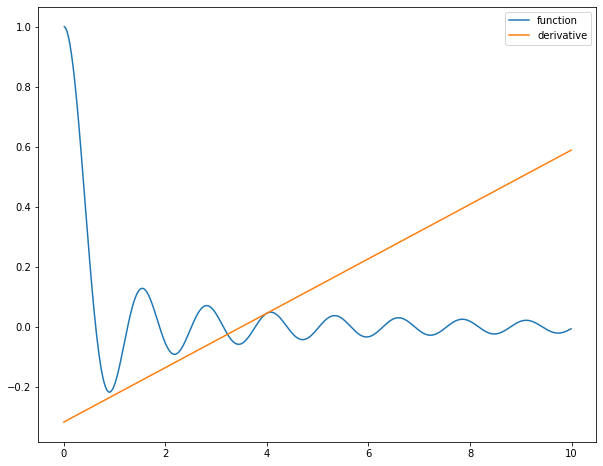

In [13]:
import matplotlib.pyplot as plt

# определяем функцию
x = tf.placeholder("float32")
y = tf.sin(x * 5) / (x * 5)

# вычисляем наклон и сдвиг графика
[slope] = tf.gradients(y, x)
bias = -slope * x + y

with tf.Session() as sess:
    plt.figure(figsize=(10,8))
    x_support = np.arange(0, 10, 0.01)
    y_res = sess.run(y, feed_dict={x: x_support})
    slope_res, bias_res = sess.run([slope, bias], feed_dict={x: 4.})
    plt.plot(x_support, y_res, label="function")
    plt.plot(x_support, slope_res * x_support + bias_res, label="derivative")
    plt.legend()
    plt.show()

Должна получиться касательная к графику функции $\sin(5x) / (5x)$ в точке x=4.

В случае, когда у нас функция y = f(x) имеет многомерный аргумент (да и возвращает она многомерное значение), Вы получите на выходе из tf.gradients также мнгомерный тензор, в котором подсчитана производная каждого элемента $y$ по каждому элементу $x$. Например, если у вас $y$ и $x$ являются одномерными массивами, то на tf.gradients вернёт двумерную матрицу $A$ производных, $A_{ij} = \cfrac{\partial y_i}{\partial x_j}$ (то есть так называемый **Якобиан**). 

По-правде можно и голову сломать, пытаясь понять, какой размерности будут тензоры после подсчёта градиентов, однако на практике сверх рассмотренных нами примеров практически ничего не бывает. Ну или бывает, но такие случаи мы рассматривать в курсе не будем. =)

## Градиентный спуск.

Подсчёт градиентов необходим нам для прямого применения методов оптимизации. Чтобы нам не приходилось постоянно программировать формулы для вычисления направлений оптимизации в разных методах, создатели tensorflow уже запрогали многое за нас. Нас будут интересовать так называемые **optimizer**'ы. Эти объекты умеют производить шаги градиентного спуска и оптимизировать произвольные функции. Попробуем с ними поиграть.

In [22]:
y_guess = tf.Variable(np.zeros(2,dtype='float32'))
y_true = tf.range(1,3,dtype='float32')

loss = tf.reduce_mean((y_guess - y_true + tf.random_normal([2]))**2) 

optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss,var_list=y_guess)

#same, but more detailed:
#updates = [[tf.gradients(loss,y_guess)[0], y_guess]]
#optimizer = tf.train.MomentumOptimizer(0.01,0.9).apply_gradients(updates)

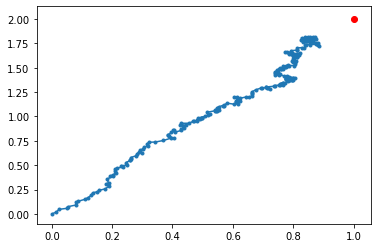

In [23]:
from IPython.display import clear_output

sess = tf.Session()
sess.run(tf.global_variables_initializer())

guesses = [sess.run(y_guess)]

for _ in range(250):
    sess.run(optimizer)
    guesses.append(sess.run(y_guess))
    
    clear_output(True)
    plt.plot(*zip(*guesses),marker='.')
    plt.scatter(*sess.run(y_true),c='red')
    plt.show()
sess.close()

## Собираем всё воедино: моя первая нейросеть.

Нейронные сети обучаются при помощи алгоритма обратного распространения ошибки (англ. backpropagation или просто backprop). Хорошая визуализация работы этого алгоритма приведена [тут](https://google-developers.appspot.com/machine-learning/crash-course/backprop-scroll/). На следующем семинаре мы в больших подробностях рассмотрим принцип его работы и даже запрограммируем его вручную при помощи библиотеки numpy, а пока что всё, что нам нужно знать -- это то, что `tensorflow` умеет **эффективно вычислять градиенты** при помощи бэкпропа.

Ниже уже идёт более приближенный к реальности код на тензорфлоу. Попробуйте разобраться с ним сами. =)

In [45]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score

tf.reset_default_graph()

mnist = load_digits()

X,y = mnist.data, mnist.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print("y [shape - %s]:" % (str(y.shape)), y[:10])
print("X [shape - %s]:" % (str(X.shape)))
n_labels = len(np.unique(y))

batch_size = 32
n_batch_train = len(X_train) // batch_size
n_batch_test = len(X_test) // batch_size

# Входные данные
X_input = tf.placeholder("float32", (None, 64))# YOUR CODE
y_input = tf.placeholder("int32", (None))# YOUR CODE

# Архитектура
z2 = tf.layers.dense(X_input, 128, activation=tf.nn.relu)
#z2 = tf.layers.dense(z1, 64, activation=tf.nn.relu)
logits = tf.layers.dense(z2, n_labels)
predictions = tf.nn.softmax(logits)

# Лосс
loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=tf.one_hot(y_input, depth=n_labels))

# Запускаемая операция одного шаша градиентного спуска.
train_op = tf.train.AdamOptimizer().minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(10):
        y_pred_array = []
        for b in range(n_batch_train):
            _, loss_ = sess.run([train_op, loss], feed_dict={X_input: X_train[b*batch_size:(b+1)*batch_size],
                                                             y_input: y_train[b*batch_size:(b+1)*batch_size]
                                                             })
        for b in range(n_batch_test + 1):
            loss_, y_pred = sess.run([loss, predictions], feed_dict={X_input: X_test[b*batch_size:(b+1)*batch_size],
                                          y_input: y_test[b*batch_size:(b+1)*batch_size]
                                         })
            y_pred_array += np.argmax(y_pred, axis=-1).tolist()
        print(accuracy_score(y_pred_array, y_test))

y [shape - (1797,)]: [0 1 2 3 4 5 6 7 8 9]
X [shape - (1797, 64)]:
0.75
0.8472222222222222
0.9083333333333333
0.9194444444444444
0.9277777777777778
0.9277777777777778
0.925
0.9333333333333333
0.9277777777777778
0.9305555555555556
